## Import das Bibliotecas e funções

In [1]:
import cv2

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import os, json, itertools

In [2]:
path = u'../data/placas/'
metadata_db = json.load(open('../data/metadata_db.json', 'r'))

In [3]:
def plot(imagem):
    plt.figure(figsize=(30,12))
    plt.imshow(imagem, cmap="gray")
    plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

In [4]:
np.random.seed(12321)

In [5]:
arq = os.listdir(path)
arq.sort()

num = 100
arq = [a for a in arq if a.startswith("track") and a.endswith(".png")]
arq = arq[:num]

In [6]:
ext = [a.replace('.png','') for a in arq]

grayscale = []

for a in arq:
    ppath = path + a
    imagem = cv2.imread(path+a, 0)
    grayscale.append(imagem)

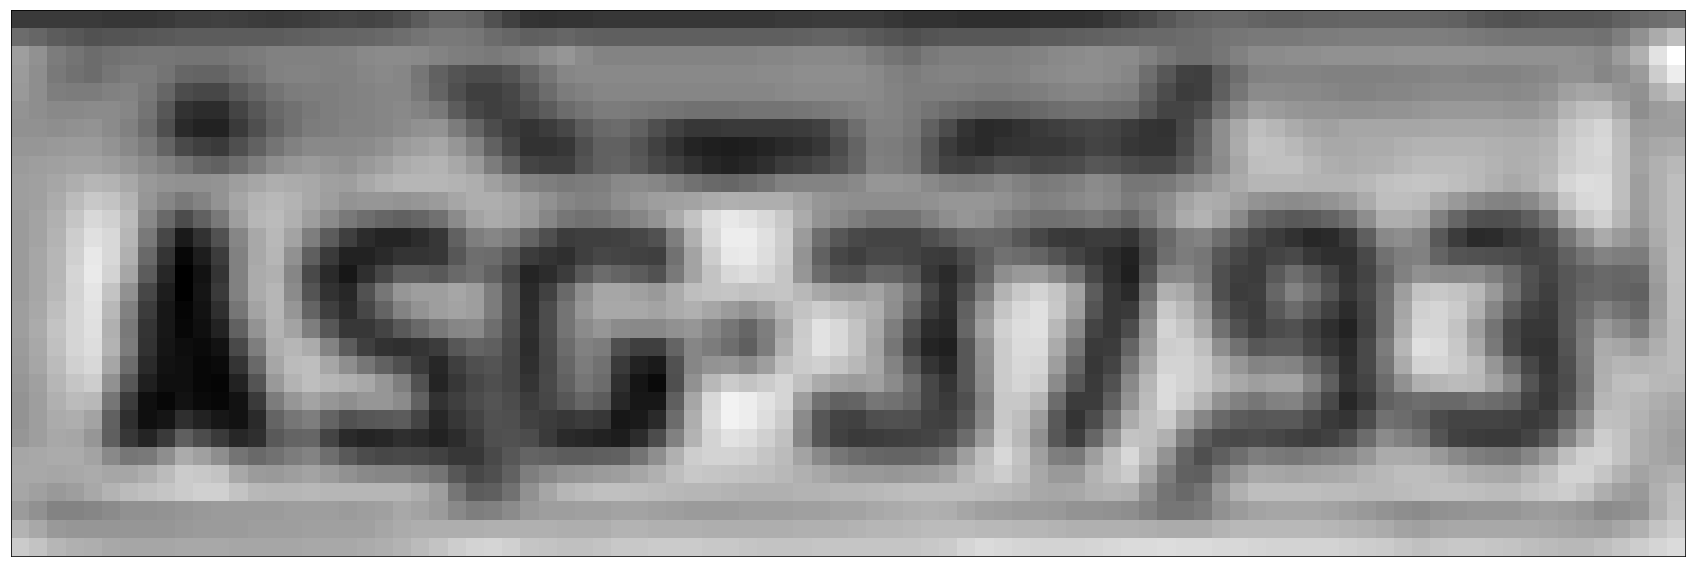

In [11]:
imagem = grayscale[90].copy()
hsv = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)
hsv = cv2.cvtColor(hsv, cv2.COLOR_BGR2HSV)
plot(imagem)

### Blurring

<BarContainer object of 64 artists>

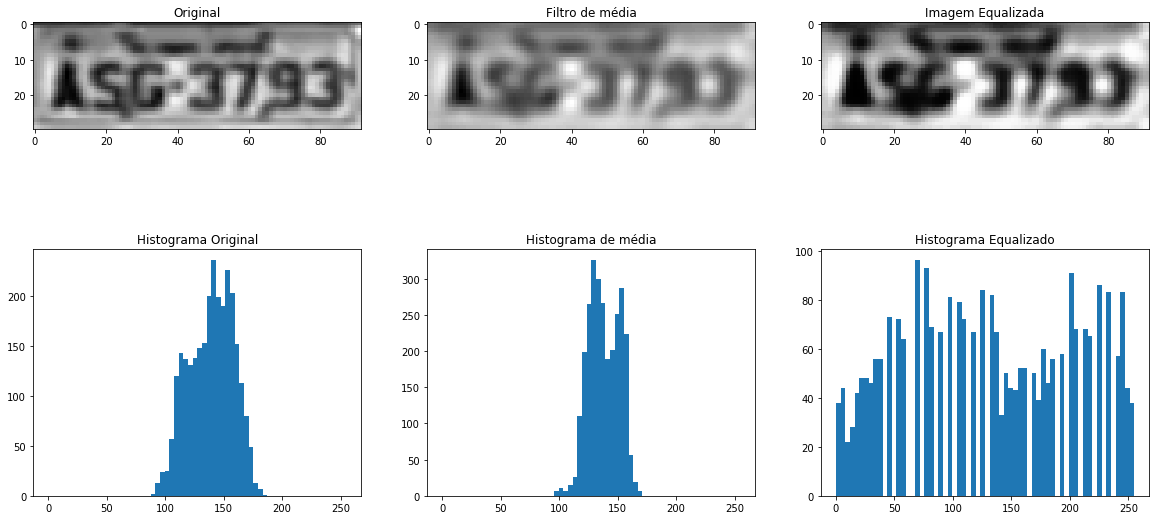

In [51]:
plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(imagem, cmap="gray")

nbins = 64
h, bin_edges = np.histogram(imagem.ravel(), nbins, (0, 255))
w = 256./nbins

bin_centers = bin_edges[1:] - (w/2)
plt.subplot(2,3,4)
plt.title("Histograma Original")
plt.bar(bin_centers, h, width=w)

###################################################################

plt.subplot(2,3,2)
teste_media = cv2.GaussianBlur(imagem.copy(), (5,5), 5, 5)
plt.title("Filtro de média")
plt.imshow(teste_media, cmap="gray")

nbins = 64
h, bin_edges = np.histogram(teste_media.ravel(), nbins, (0, 255))
w = 256 / nbins

bin_centers = bin_edges[1:] - (w/2)
plt.subplot(2,3,5)
plt.title("Histograma de média")
plt.bar(bin_centers, h, width=w)

###################################################################

plt.subplot(2,3,3)
teste_eql = cv2.equalizeHist(teste_media.copy(), (3,3))
plt.title("Imagem Equalizada")
plt.imshow(teste_eql.copy(), cmap="gray")

nbins = 64
h, bin_edges = np.histogram(teste_eql.ravel(), nbins, (0, 255))
w = 256 / nbins

bin_centers = bin_edges[1:] - (w/2)
plt.subplot(2,3,6)
plt.title("Histograma Equalizado")
plt.bar(bin_centers, h, width=w)

### Thresholding

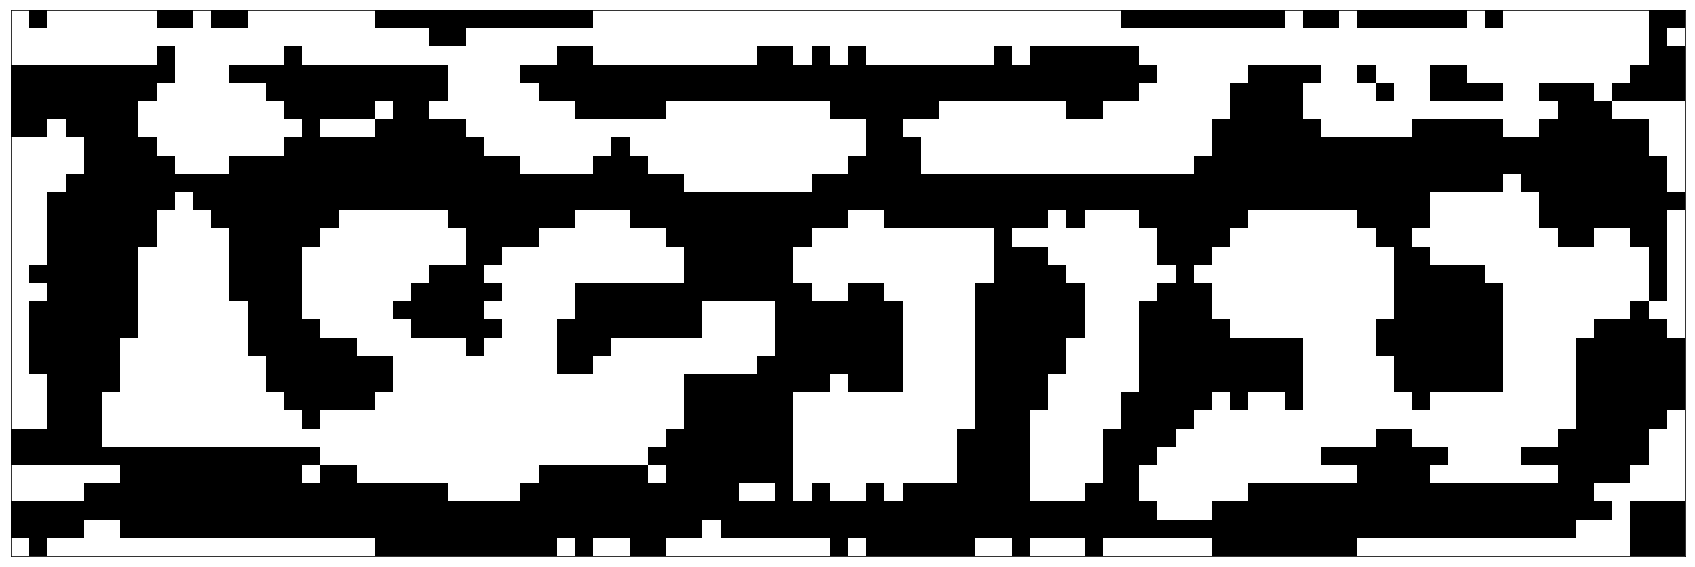

In [52]:
thr = cv2.adaptiveThreshold(teste_eql.copy(), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 0)
plot(thr)

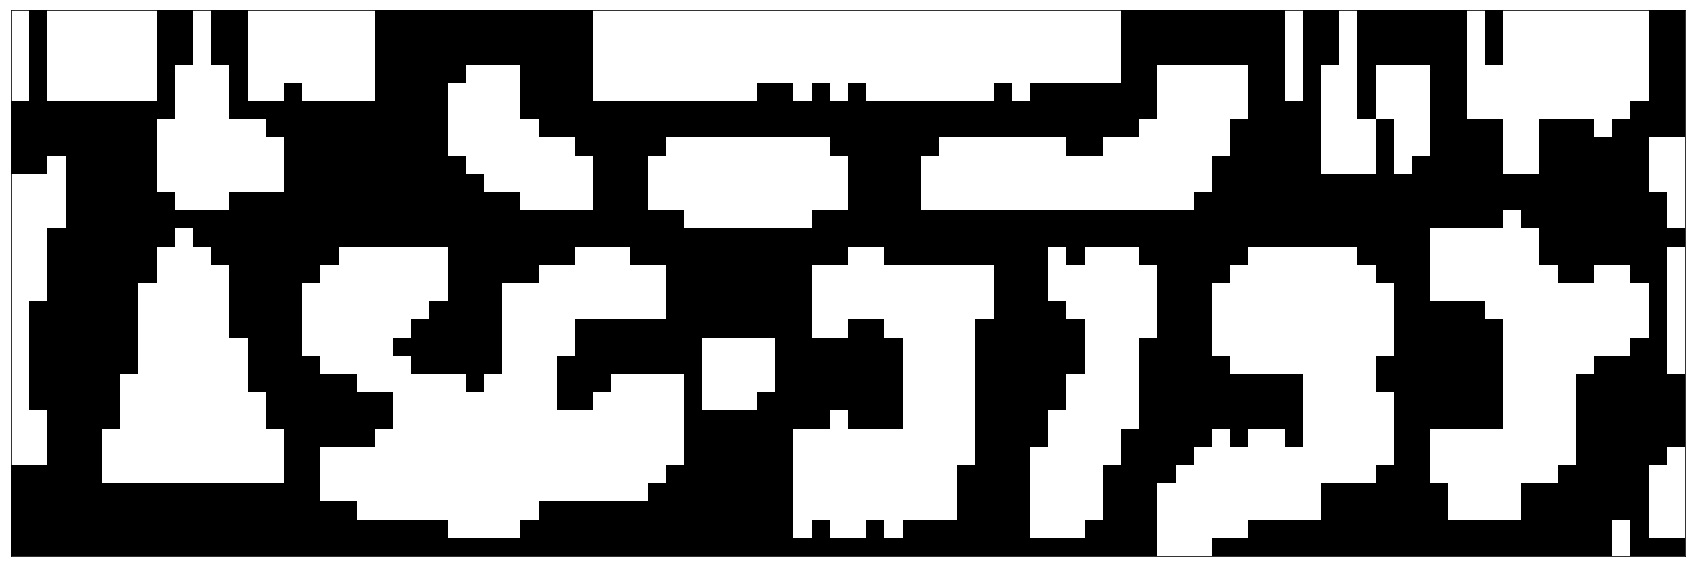

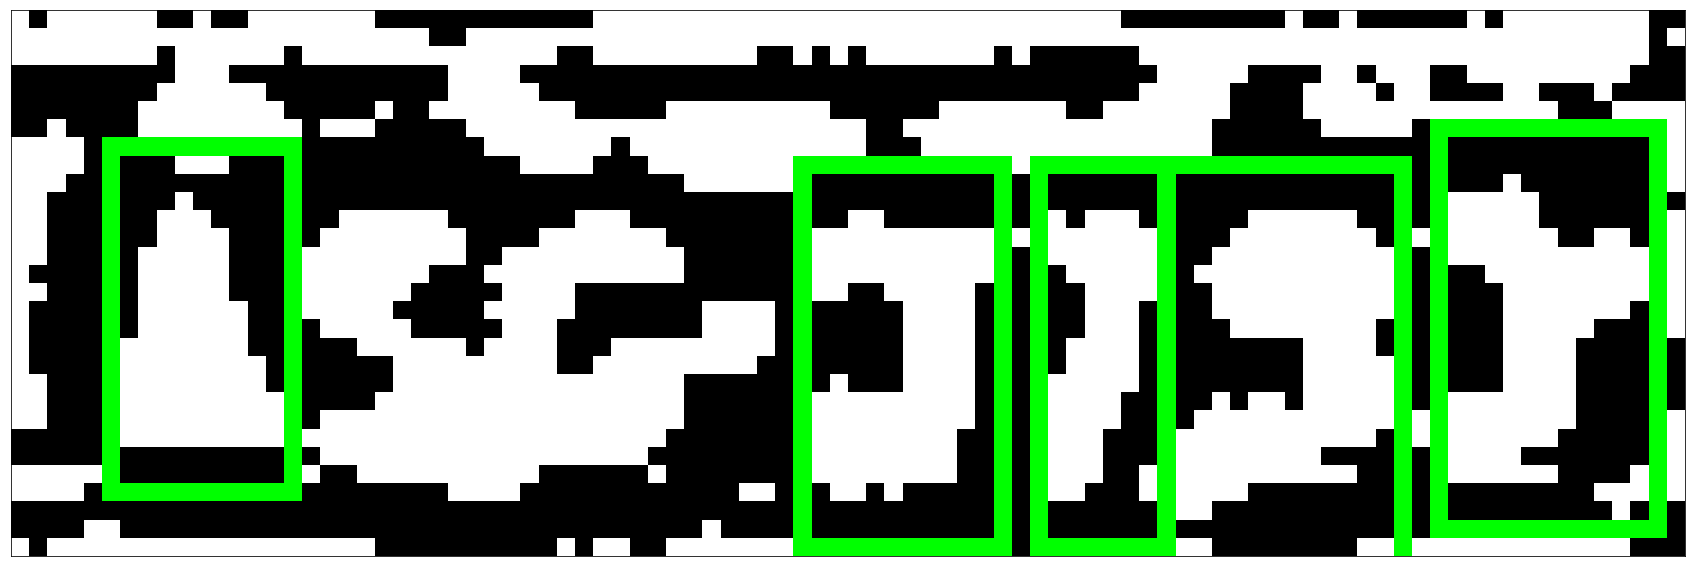

In [53]:
closed1 = cv2.morphologyEx(thr.copy(), cv2.MORPH_OPEN, (5,5), iterations=2)
_, ctrs1, _ = cv2.findContours(closed1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plot(closed1)

here1 = thr.copy()
here1 = cv2.cvtColor(here1, cv2.COLOR_GRAY2BGR)
for cnt in ctrs1:
    (x, y, w, h) = cv2.boundingRect(cnt)
    if (12 < h < 20 and 3 < w < 15 and 3 < x < 89):
        cv2.rectangle(here1, (x,y-5), (x+w,y+h), (0, 255, 0), 1)
plot(here1)

In [87]:
def pipeline(image):
    teste_media = cv2.GaussianBlur(image.copy(), (7, 7), 21, 21)
    teste_eql = cv2.equalizeHist(teste_media.copy(), (5,5))
    thr = cv2.adaptiveThreshold(teste_eql.copy(), 255, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 3, 0)
    closed1 = cv2.morphologyEx(thr.copy(), cv2.MORPH_OPEN, (3,3), iterations=2)
    _, ctrs1, _ = cv2.findContours(closed1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    n = 0
    for cnt in ctrs1:
        (x, y, w, h) = cv2.boundingRect(cnt)
        if (12 < h < 20 and 3 < w < 15 and 3 < x < 89):
            n += 1
            
    return n

In [88]:
score = sum(pipeline(g) for g in grayscale)
score

403

In [ ]:
from sklearn.base import BaseEstimator
class Segmentation(BaseEstimator):
    def __init__(self, g_kernel, g_sx, g_sy, eql_kernel, adap_thr_kernel, close_kernel):
        self.gk = g_kernel
        self.gsx = g_sx
        self.gsy = g_sy
        self.eqlk = eql_kernel
        self.adthrk = adap_thr_kernel
        self.ck = close_kernel
        
    def _pipeline(self, image):
        teste_media = cv2.GaussianBlur(image.copy(), self.gk, self.gsx, self.gsy)
        teste_eql = cv2.equalizeHist(teste_media.copy(), self.eqlk)
        thr = cv2.adaptiveThreshold(teste_eql.copy(), 255, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, self.adthrk, 0)
        closed1 = cv2.morphologyEx(thr.copy(), cv2.MORPH_OPEN, self.close_kernel, iterations=2)
        _, ctrs1, _ = cv2.findContours(closed1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        n = 0
        for cnt in ctrs1:
            (x, y, w, h) = cv2.boundingRect(cnt)
            if (12 < h < 20 and 3 < w < 15 and 3 < x < 89):
                n += 1

        return n
        
    def score(self, img_seq):
        return sum(self._pipeline(i) for i in img_seq)

In [ ]:
seg_params = {
    "g_kernel": ,
    "g_sx": ,
    "g_sy": ,
    "eq_kernel": ,
    "adap_thr_kernel": ,
    "close_kernel": ,
}